# Method Comparisons: BOSC

Comparing FOOOF to other related methods.

This notebook compares FOOOF to [BOSC](https://www.sciencedirect.com/science/article/abs/pii/S1053811910011614), 
the 'Better Oscillation Detector'. 

Note that FOOOF and BOSC are related in the sense that both use a measure of aperiodic activity to isolate periodic activity, but otherwise they are overall fundamentally fairly different. Notably, BOSC uses an aperiodic measure as a threshold to attempt to measure the relative power of oscillations in the time domain, whereas FOOOF operates in the frequency domain. In this notebook we will compare FOOOF to the aperiodic measure that BOSC uses - a linear fit in log-log space, as this is the most direct comparison that can be made.  


In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
from scipy.stats import ttest_rel

from fooof import FOOOF
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import plot_errors_violin
from sims import gen_peak_def, gen_ap_def, gen_ap_knee_def
from utils import save_sim_data, load_sim_data
from analysis import cohens_d
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '07_comp-bosc/'

In [7]:
# Run Settings
GEN_SIMS = True
SAVE_SIMS = True
SAVE_FIG = True
PLT_LOG = True

In [8]:
# Data settings
n_psds = 1000
nlv = 0.005

## Helper Functions

In [9]:
# Fixed fit function
from scipy.optimize import curve_fit
from fooof.core.funcs import linear_function
def fit_ap_ln(freqs, psd_ap):
    """Fit an aperiodic component with a linear function."""
    popt, _ = curve_fit(linear_function, np.log10(freqs), np.log10(psd_ap), p0=[0, 0])
    return popt[0], popt[1]

In [10]:
def fit_all_lin(psds, sim_params, knee=False):
    """Fit and compute error with a linear fit."""

    ind = 2 if knee else 1
    
    errs = []
    for psd, params in zip(psds, sim_params):
        off, exp = fit_ap_ln(freqs, psd)
        errs.append(np.abs(-exp - params.aperiodic_params[ind]))
    return errs


def fit_all_fooof(psds, sim_params, knee=False):
    """Fit and compute error with FOOOF."""

    settings = FOOOF_SETTINGS_KNEE if knee else FOOOF_SETTINGS
    ind = 2 if knee else 1
    fm = FOOOF(*settings, verbose=False)
    
    errs = []
    for psd, params in zip(psds, sim_params):
        fm.fit(freqs, psd)
        errs.append(np.abs(fm.aperiodic_params_[ind] - params.aperiodic_params[ind]))
    return errs

## 1 Peak

In [11]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

In [12]:
# Generate or load power spectra
data_name = 'comp_bosc_1p'

if GEN_SIMS:
    
    # Generate simulated power spectra
    freqs, psds, sim_params = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv,
                                    F_RES, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_spectra, n_freqs : ', psds.shape)

n_spectra, n_freqs :  (1000, 153)


In [13]:
#
lin_errs_1p = fit_all_lin(psds, sim_params)
foo_errs_1p = fit_all_fooof(psds, sim_params)

errs_1p = np.array([lin_errs_1p, foo_errs_1p])

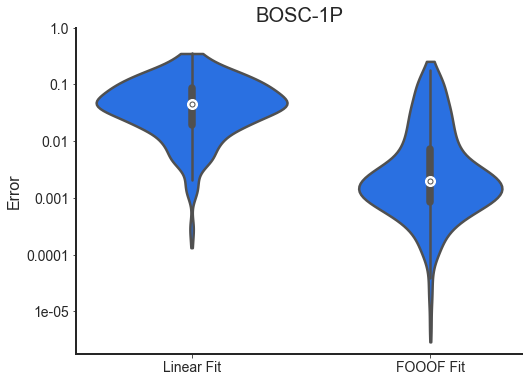

In [14]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(errs_1p, 'BOSC-1P', x_axis=None,
                   plt_log=PLT_LOG, ylim=YLIMS_AP, x_ticks=['Linear Fit', 'FOOOF Fit'],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'BOSC-1p'))

In [15]:
# Check mean and standard deviation of the errors
print('Linear fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(lin_errs_1p), np.std(lin_errs_1p)))
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(foo_errs_1p), np.std(foo_errs_1p)))

Linear fits: 	 0.0641 	0.0645
FOOOF fits: 	 0.0131 	0.0310


In [16]:
# Check t-test comparison
t_val, p_val = ttest_rel(lin_errs_1p, foo_errs_1p)
print('T-test: {:1.5f}, {}'.format(t_val, p_val))

T-test: 37.66103, 6.63914330655583e-194


In [17]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(lin_errs_1p, foo_errs_1p)))

Cohens-D: 1.0097


## Multi-Peak

In [18]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(3)
aps = gen_ap_def()

In [19]:
# Generate or load power spectra
data_name = 'comp_bosc_mp'

if GEN_SIMS:

    # Generate simulated power spectra
    freqs, psds, sim_params = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv,
                                    F_RES, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_spectra, n_freqs : ', psds.shape)

n_spectra, n_freqs :  (1000, 153)


In [20]:
#
lin_errs_mp = fit_all_lin(psds, sim_params)
foo_errs_mp = fit_all_fooof(psds, sim_params)

errs_mp = np.array([lin_errs_mp, foo_errs_mp])

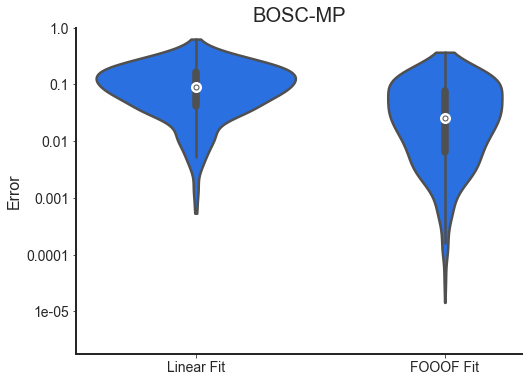

In [21]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(errs_mp, 'BOSC-MP', x_axis=None,
                   plt_log=PLT_LOG, ylim=YLIMS_AP, x_ticks=['Linear Fit', 'FOOOF Fit'],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'BOSC-mp'))

In [22]:
# Check mean and standard deviation of the errors
print('Linear fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(lin_errs_mp), np.std(lin_errs_mp)))
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(foo_errs_mp), np.std(foo_errs_mp)))

Linear fits: 	 0.1152 	0.0974
FOOOF fits: 	 0.0514 	0.0625


In [23]:
# Check t-test comparison
t_val, p_val = ttest_rel(lin_errs_mp, foo_errs_mp)
print('T-test: {:1.5f}, {}'.format(t_val, p_val))

T-test: 33.53949, 8.307323720250694e-166


In [24]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(lin_errs_mp, foo_errs_mp)))

Cohens-D: 0.7800


## Knee

In [25]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_knee_def()

In [26]:
# Generate or load power spectra
data_name = 'comp_bosc_kn'

if GEN_SIMS:

    # Generate simulated power spectra
    freqs, psds, sim_params = \
            gen_group_power_spectra(n_psds, F_RANGE_LONG, aps, peaks, nlv,
                                    F_RES_LONG, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_spectra, n_freqs : ', psds.shape)

n_spectra, n_freqs :  (1000, 199)


In [27]:
#
lin_errs_kn = fit_all_lin(psds, sim_params, knee=True)
foo_errs_kn = fit_all_fooof(psds, sim_params, knee=True)

errs_kn = np.array([lin_errs_kn, foo_errs_kn])

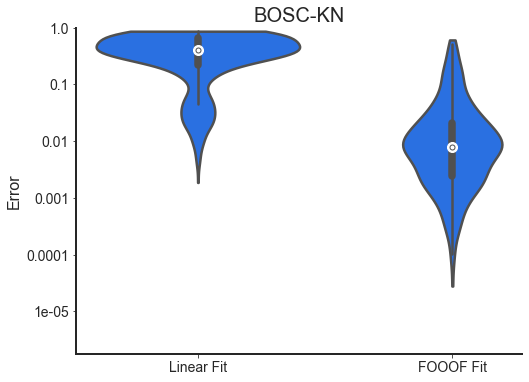

In [28]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(errs_kn, 'BOSC-KN', x_axis=None,
                   plt_log=PLT_LOG, ylim=YLIMS_AP, x_ticks=['Linear Fit', 'FOOOF Fit'],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'BOSC-kn'))

In [29]:
# Check mean and standard deviation of the errors
print('Linear fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(lin_errs_kn), np.std(lin_errs_kn)))
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(foo_errs_kn), np.std(foo_errs_kn)))

Linear fits: 	 0.4078 	0.2591
FOOOF fits: 	 0.0302 	0.0721


In [30]:
# Check t-test comparison
t_val, p_val = ttest_rel(lin_errs_kn, foo_errs_kn)
print('T-test: {:1.5f}, {}'.format(t_val, p_val))

T-test: 45.77963, 1.5857891996118487e-247


In [31]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(lin_errs_kn, foo_errs_kn)))

Cohens-D: 1.9856
